# Prendre en main l'API Python d'ArcGIS - épisode 8
## Publication d'un Notebook en tant qu'outil web

ArcGIS Notebooks vous permet de publier des notebooks en tant qu'outils web (web tools) auxquels les membres de votre organisation peuvent accéder avec des applications clientes qui fonctionnent avec des services de géotraitement asynchrones RESTful, tels que Map Viewer et ArcGIS Experience Builder. Dans ce huitième tutoriel de notre **[série consacrée à la prise en main de l'API Python d'ArcGIS](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html)**, nous allons apprendre comment paramétrer et publier notre Notebook en tant qu'outil web. Pour cela, nous allons utiliser un script consommant un service d'itiniraires pour créer un trajet entre un point de départ et d'arrivée. Le script fera appel aux données du [National Renewable Energy Laboratory (NREL)](https://www.nrel.gov/) afin de localiser les stations de recharge pour véhicules électriques le long de la route.

 Voici les étapes que nous allons suivre :
 - [1/ Préparation du Notebook](#1/-Préparation-du-Notebook)
 - [2/ Configuration des paramètres d'entrée](#2/-Configuration-des-paramètres-d'entrée)
 - [3/ Calcul d'un itinéraire en utilisant des valeurs par défaut](#3/-Calcul-d'un-itinéraire-en-utilisant-des-valeurs-par-défaut)
 - [4/ Requête des stations de recharge le long de la route](#4/-Requête-des-stations-de-recharge-le-long-de-la-route)
 - [5/ Configuration des paramètres de sortie](#5/-Configuration-des-paramètres-de-sortie)
 - [6/ Publication du Notebook en tant qu'outil web](6/-Publication-du-Notebook-en-tant-qu'outil-web)
 - [7/ Exécution du Notebook dans des applications clientes](#7/-Exécution-du-Notebook-dans-des-applications-clientes)

### 1/ Préparation du Notebook

Dans cette étape, nous allons préparer le notebook afin de pouvoir le publier en tant qu'outil web. Pour cela, vous aller devoir le sauvegarder, puis importer les bibliothèques nécessaires et vous connecter au GIS.

1. Sauvegardez le Notebook afin d'en posséder une instance. Cette étape est obligatoire car vous devez être propriétaire du Notebook pour pouvoir le publier en tant qu'outil web. .
   1. Cliquez sur **Enregistrer** > **Enregistrer sous**.
   2. Nommez le Notebook comme vous le souhaitez, et ajoutez les balises et le résumé de votre choix .
   3. Cliquez sur **Sauvegarder le Notebook**.

>**Note**: Vous devez posséder le privilège ["Publier des outils web"](https://doc.arcgis.com/fr/arcgis-online/administer/privileges-for-roles-orgs.htm#ESRI_SECTION1_41D9146A73474E10A94E5EBBE3A79114) afin de pouvoir publier un Notebook en tant que webtool. Si vous ne voyez pas les options **Paramètres** or **Publier** dans le bandeau en haut de l'interface une fois que vous avez enregistré le Notebook, contactez l'un de vos administrateur afin qu'il vous assigne un rôle possédant ce privilège. 

2. La cellule ci-dessous permet d'importer toutes les bibliothèques qui nous seront nécessaires pour l'analyse que nous souhaitons effectuer. 

In [ ]:
#import des bibliothèques Python
import requests #envoi des requêtes HTTP
import json #travail avec les données JSON
    
import pandas as pd #travail avec les données tabulaires
from shapely.geometry import LineString  #manipulation des objets géométriques
    
from arcgis.network import RouteLayer #classe de l'API Python d'ArcGIS pour l'analyse de réseaux 
from arcgis.features import FeatureSet #classe de l'API Python d'ArcGIS pour travailler avec des entités 

import warnings
warnings.filterwarnings("ignore")

3. Enfin, vous pouvez vous connecter à votre organisation ArcGIS :

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

### 2/ Configuration des paramètres d'entrée

Maintenant que le Notebook est préparé, nous allons pouvoir y ajouter des paramètres d'entrée et des variables. Pour ce Notebook dont le but est de calculer un itinéraire et de localiser les bornes de recharges électriques, les variables d'entrée sont :
 - Le point de départ - `point_start`
 - La point d'arrivée - `point_end`
 - La distance autour de la route dans la The distance from the route to search for EV charging stations within - `distance`
 - Une option pour expoter la liste des stations de recharge en tant que fichier CSV - `export_charging_stations`

1. Commençons par créer les variables `point_start`, `point_end`, `distance`, et `export_charging_stations`. Vous pouvez voir que `point_start` et `point_end` sont des [FeatureSets](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featureset) contenant les localisations de deux bureaux d'Esri à Charlotte Waverly et à Arboretum, et que la valeur de `distance` est de 2. Le paramètre `export_charging_stations` est une valeur bouléenne qui donnera une case à cocher ou à décocher.

**Notes:**
 - Pour ce tutoriel, nous utiliserons comme points de départ et d'arrivée par défaut deux bureaux d'Esri. L'outil permettra cependant à l'utilisateur de choisir ses propres points.
 - Les unités utilisées pour la variable `distance` sont définies dans [l'API nearby-route du NREL](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/nearby-route/) de laquelle viennent les données sur les stations de recharge.

In [ ]:
point_start = {
  "geometryType": "esriGeometryPoint",
  "spatialReference": {
    "wkid": 3857
  },
  "fields": [
    {
      "name": "id",
      "type": "esriFieldTypeOID",
      "alias": "ID"
    },
    {
      "name": "Name",
      "type": "esriFieldTypeString",
      "alias": "Name"
    }
  ],
  "features": [
    {
      "geometry": {
        "x": -8990823.035941353,
        "y": 4170856.4960864866,
        "spatialReference": {
          "wkid": 3857
        }
      },
      "attributes": {
        "id": 0,
        "Name": "Esri Charlotte - Waverly"
      }
    }
  ]
}
point_end = {
  "geometryType": "esriGeometryPoint",
  "spatialReference": {
    "wkid": 3857
  },
  "fields": [
    {
      "name": "id",
      "type": "esriFieldTypeOID",
      "alias": "ID"
    },
    {
      "name": "Name",
      "type": "esriFieldTypeString",
      "alias": "Name"
    }
  ],
  "features": [
    {
      "geometry": {
        "x": -8992543.27195127,
        "y": 4177502.727147686,
        "spatialReference": {
          "wkid": 3857
        }
      },
      "attributes": {
        "id": 1,
        "Name": "Esri Charlotte - Arboretum"
      }
    }
  ]
}
distance = 2
export_charging_stations = True

2. Nous allons maintenant ajouter les paramètres d'entrée `point_start`, `point_end`, `distance`, `export_charging_stations` au Notebook. 
   1. Dans le bandeau du haut, cliquez sur **Paramètres**, puis sur **Ajouter**.
   2. Ajoutez `point_start` comme paramètre d'entrée (sélectionnez "Entrée" pour le sens) et renseignez les valeurs suivantes :
      - Nom de variable : point_start
      - Nom d'affichage : Point de départ
      - Type de données : Jeu d'entités
      - Valeur par défaut : utilisez la valeur de la variable `point_start` définie dans la cellule ci-dessus.  _N'incluez pas le nom de la variable, mais seulement sa valeur comme dans la capture d'écran ci-dessous._
      
      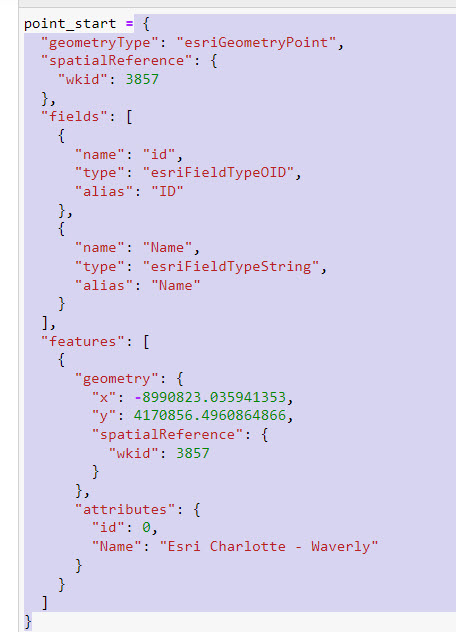
      
      - Description: Point de départ de l'itinéraire (origine).
      - Cliquez sur **Enregistrer**.
   3. De la même manière, ajoutez `point_end` aux paramètres d'entrée.
      - Nom de variable : point_end
      - Nom d'affichage : Destination
      - Type de données : Jeu d'entités
      - Valeur par défaut : utilisez la valeur de la variable `point_end` définie dans la cellule ci-dessus.  _N'incluez pas le nom de la variable, mais seulement sa valeur._
      - Description: Point d'arrivée de l'itinéraire (destination).
      - Cliquez sur **Enregistrer**.
   4. Ajoutez également `distance` aux paramètres d'entrée.
      - Nom de variable : distance
      - Nom d'affichage : Distance (en miles) à la route dans laquelle chercher des stations de recharge
      - Type de données : Double
      - Valeur par défaut : 2
      - Description: Valeur comprise entre 0 et 100.
      - Cliquez sur **Enregistrer**.
   5. Enfin, ajoutez `export_charging_stations` comme dernier paramètre d'entrée.
      - Nom de variable : export_charging_stations
      - Nom d'affichage : Exporter les stations de recharge
      - Type de données : Booléen
      - Valeur par défaut : True
      - Description: Sélectionnez cette option pour exporter la liste des stations de recharge en tant que fichier CSV.
      - Cliquez sur **Enregistrer**.

Grâce à la configuration de ces 4 variables en tant que paramètre d'entrée, l'utilisateur final pourra facilement en modifier les valeurs juste avant l'exécution de l'outil dans le Map Viewer ou Experience Builder sans avoir à ouvrir, modifier ou exécuter le Notebook.

3. Cliquez sur cette cellule, puis sélectionnez l'option **Insérer comme variables** de l'onglet **Paramètres**.
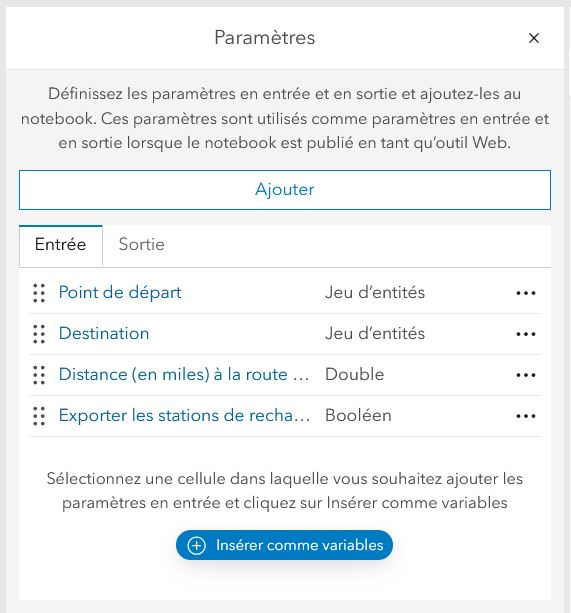

Cela devrait insérer une nouvelle cellule de code ci-dessous. Elle ressemble à celle de l'étape 1 où nous avions créé les variables `point_start`, `point_end`, `distance`, et `export_charging_stations`, à l'exception que celle-ci possède un tag "parameters". Cela signifie que lorsque l'outil web s'exécutera, il cherchera cette cellule grâce à ce tag et y passera les valeurs renseignées par l'utilisateur. 
   
    Si vous souhaitez voir les tags de votre cellule, cliquez sur **View** dans le ruban supérieur, puis sur **Cell Toolbar** -> **Tags**.
    
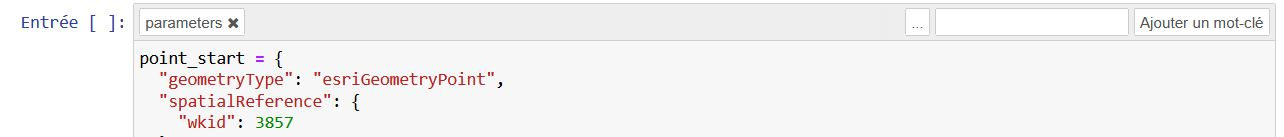

   Maintenant que nous avons inséré une nouvelle cellule avec les valeurs par défaut des variables d'entrée avec le tag "paramètre", vous pouvez supprimer la cellule de création des variables de l'étape 1.

4. Exécutez la cellule que vous venez d'ajouter pour créer les variables `point_start`, `point_end`, `distance`, et `export_charging_stations`. 

5. La cellule ci-dessus récupère le [`featureSet`](https://developers.arcgis.com/web-map-specification/objects/featureSet/) pour les valeurs d'entrée de `point_start` et `point_end` dans le cas où ils sont transmis par l'outil web en tant que couches. Les valeurs de ces `featureSet` seront ensuite utilisées pour calculer l'itinéraire. Vous n'avez pas à exécuter cette cellule. 

In [ ]:
#formatage des points d'entrée en FeatureSet
try:
    if "featureSet" in point_start.keys():
        point_start = point_start["featureSet"]
    if "featureSet" in point_end.keys():
        point_end = point_end["featureSet"]
    if "itemId" in point_start.keys():
        point_start = gis.content.get(point_start["itemId"]).layers[0].query().to_dict()
    if "itemId" in point_end.keys():
        point_end = gis.content.get(point_end["itemId"]).layers[0].query().to_dict()
except:
    print('Did not find "featureSet" in the input points. The input point(s) is already a FeatureSet. ')

### 3/ Calcul d'un itinéraire en utilisant des valeurs par défaut

Nous allons maintenant calculer un itinéraire entre les points de départ et d'arrivée par défait en utilisant les services de route de votre SIG (ArcGIS Enterprise or ArcGIS Online). Nous utiliserons le résultat pour configurer un paramètre de sortie de l'outil web dans une étape suivante.  

1. Exécutez la cellule ci-dessous pour accéder à l'URL du service de route de votre SIG et créer un [`RouteLayer`](https://developers.arcgis.com/python/api-reference/arcgis.network.toc.html#routelayer). Un `RouteLayer` est une couche spécifique pour visualiser et calculer des routes. 

In [ ]:
#accès à l'URL du service de route
route_service_url = gis.properties.helperServices.route.url

#création du RouteLayer
route_layer = RouteLayer(route_service_url, gis=gis)

2. Vous pouvez ensuite exécuter les trois cellules ci-dessous pour :
 - A) préparer une variable `stops` en entrée pour la fonction `arcgis.network.RouteLayer.solve()`.
 - B) utiliser `solve()` pour calculer les routes entre le point de départ par défaut (Esri Charlotte - Waverly) et la destination par défaut (Esri Charlotte - Arboretum).
 - C) Créer une variable `route` contenant le premier résultat renvoyé par `solve()`. 

In [ ]:
#création des stops pour la fonction arcgis.network.RouteLayer.solve()
stops = {"features": []}
stops["features"] = [point_start["features"][0], point_end["features"][0]]
stops_input = json.dumps(stops)

In [ ]:
#calcul de l'itinéraire
solve_result = route_layer.solve(
    stops=stops_input,
    return_directions=False, 
    return_routes=True
)

In [ ]:
#stockage du résultat du calcul dans une variable
route = {"features": []}
route["features"] = [solve_result["routes"]["features"][0]]

3. Nous pouvons ensuite retirer les attributs inutiles de la route calculée ci-dessus :

In [ ]:
route_attr = route["features"][0]["attributes"]
route_attr_pp = ["ObjectID", "Total_TravelTime", "Total_Miles", "Total_Kilometers"]
route["features"][0]["attributes"] = dict(
    filter(
        lambda x: x[0] in route_attr_pp, route_attr.items()
    )
)

4. Enfin, nous convertissons la route en [FeatureSet](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#featureset), lui assignons une référence spatiale et imprimons sa valeur dans le Notebook. 

In [ ]:
output_route = FeatureSet.from_dict(route)
output_route.spatial_reference = solve_result["routes"]["spatialReference"]
print(output_route)

### 4/ Requête des stations de recharge le long de la route

Notre outil web va requêter l'[API nearby-route](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/nearby-route/) du NREL afin d'obtenir les stations de recharges pour véhicules électriques le long de l'itinéraire. Dans cette étape, nous allons obtenir une clé d'API gratuite pour utiliser les services du NREL, construire une requête contenant les paramètres nécessaires pour interroger l'API nearvy-route et imprimer le résultat de la liste des stations. . 

1. Rendez-vous sur la page [API Key Signup](https://developer.nrel.gov/signup/) du NTEL. Remplissez le formulaire avec votre **Prénom (First Name)**, **Nom (Last Name)**, **Email**, etc., acceptez les termes et conditions et cliquez sur **Signup**.
   
   Une nouvelle page va apparaître pour vous indiquer que votre clé d'API va être envoyée à l'adresse email que vous avez renseugnée. Notez que cette clé d'API est personnelle et ne doit pas être partagée.

2. Dans la cellule ci-dessous, remplacez \<YOUR_NREL_API_KEY\> avec la clé que vous venez de générer.

In [ ]:
api_key = "<YOUR_NREL_API_KEY>"
request_url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1/nearby-route.geojson?api_key={api_key}"

3. L'API nearby-route attend que le paramètre `route` soit passé sous la forme d'un well-known text (WKT) LineString. Nous convertissons donc l'itinéraire obtenu à l'étape précédente en LineString :

In [ ]:
route_geometry = solve_result["routes"]["features"][0]["geometry"]["paths"][0]
route_ls = LineString(route_geometry)

4. Nous créons ensuite un dictionnaire contenant les paramètres qui seront envoyés à l'API. Vous pouvez consulter [cette page](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/nearby-route/#request-parameters) pour en apprendre plus sur les paramètres de requête que l'API prend en charge. 

In [ ]:
params = {
    "route": route_ls,
    "distance": distance,
    "status": "E",
    "access": "public",
    "fuel_type": "ELEC"
}

5. Les deux cellules suivantes vont nous permettre de :
 - A) envoyer une requête à l'API nearby-route API avec les paramètres définis ci-dessus.
 - B) convertir la réponse de l'API en FeatureSet et la stocker dans la variable `stations_allfields`. 

In [ ]:
x = requests.post(request_url, data=params)

In [ ]:
stations_allfields = FeatureSet.from_geojson(json.loads(x.text))

6. De la même manière que pour l'itinéraire, le résultat de la requête contient des attributs qui ne seront pas nécessaires à notre outil web. Nous allons donc stocker les résultats dans la variable  `stations_sdf_attr` en ne conservant que les attributs nécessaires ('access_days_time', 'station_name', 'station_phone', etc..).

   Vous pouvez consulter [cette page](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/nearby-route/#response-fields) pour en apprendre plus sur les champs contenus dans les réponses de l'API nearby-route. 

In [ ]:
stations_sdf = stations_allfields.sdf
stations_attr_pp = [
    "access_days_time", "station_name", "station_phone",
    "street_address", "city", "state", "zip",
    "ev_network", "ev_network_web",
    "distance", "distance_km", "SHAPE",
    "OBJECTID"
]
stations_sdf_attr = stations_sdf.loc[:, stations_attr_pp]

7. Nous pouvons ensuite convertir le résultat en FeatureSet et imprimer sa valeur.

In [ ]:
#convertion en FeatureSet
stations = FeatureSet.from_dataframe(stations_sdf_attr)
print(stations)

8. Enfin, nous générons le fichier CSV contenant les stations de recharge qui sera exporté si l'option **Exporter les stations de recharge** de l'outil est activée.

In [ ]:
if export_charging_stations:
    csv_path = "stations.csv"
    stations_sdf.to_csv(csv_path)
    stations_csv = {"url": csv_path}

### 5/ Configuration des paramètres de sortie

Maintenant que l'itinéraire et les stations de recharge basés sur les valeurs d'entrée par défaut ont été calculés, nous allons pouvoir configurer les paramètres de sortie de notre outil web. L'outil contiendra trois paramètres de sortie :
 - L'itinéraire entre les points de départ et d'arrivée - `output_route`
 - Les stations de recharge se trouvant dans la distance indiquée autour de la route - `stations`
 - Un fichier CSV contenant les informations sur les stations de recharge - `stations_csv`

1. Ajoutez `output_route`, `stations`, et `stations_csv` en tant que paramètres de sortie. 
   1. Sur le bandeau supérieur, cliquez sur **Paramètres**, puis **Ajouter**.
   2. Ajoutez `output_route` en tant que paramètre de sortie (sélectionnez "Sortie (applicable aux outils Web uniquement)" pour le sens) avec les valeurs suivantes :
      - Nom de variable : output_route
      - Nom d'affichage : Itinéraire entre le point de départ et le point d'arrivée
      - Type de données : Jeu d'entités
      - Valeur par défaut : copiez les résultats issus du `print(output_route)` de l'étape 4 de la section 3.
      - Description : Résultat : Itinéraire entre le point de départ et le point d'arrivée.
      - Cliquez sur **Enregistrer**.
   3. De la même manière, ajoutez le paramètre de sortie `stations` :
      - Nom de variable : stations
      - Nom d'affichage : Stations de recharge des véhicules électriques
      - Type de données : Jeu d'entités
      - Valeur par défaut : copiez les résultats issus du `print(stations)` de l'étape 7 de la section 4.
      - Description : Résultat : Stations de recharge.
      - Cliquez sur **Enregistrer**.
   3. Enfin, ajoutez `stations_csv` :
      - Nom de variable : stations_csv
      - Nom d'affichage : Export CSV des stations de recharge des véhicules électriques 
      - Type de données : Fichier
      - Valeur par défaut : {"url": ""}
      - Description : Fichier CSV contenant les informations sur les stations de recharge le long de l'itinéraire.
      - Cliquez sur **Enregistrer**.
   
Ces trois variables étant configurées comme paramètres de sortie, l'outil web pourra calculer leur valeur selon les la valeur des paramètres d'entrée fournis par l'utilisateur et les calculs exécutés dans le Notebook, puis fournir les résultats à l'utilisateur.

2. Cliquez sur cette cellule, puis passez dans l'onglet **Sorite** du panneau **Paramètres**. Cliquez sur le signe plus à côté de chacun des trois paramètres. Cela va rajouter trois nouvelles cellules à votre code similaires aux cellules commentées déjà insérées si dessous pour l'exemple. Vous n'avez pas besoin d'exécuter les cellules insérées à cette étape.

3. Afin de gérer le scénario où l'utilisareur ne souhaite pas exporter le CSV, vous devrez éditer légèrement la troisième cellule en insérant une ligne de code permettant d'exécuter la cellule seulement si le paramètre `export_charging_stations` est à True.
    Au début de la troisième cellule, ajoutez cette condition if et indentez tout le code en-dessous :
    
     - _if export_charging_stations_:
    
    Vous pouvez indenter toutes les lignes de code en une seule fois en les sélectionnant puis en cliquant sur **Tab**.
    

In [ ]:
# # Inserted snippet writes output parameter file for web tool execution
# import os
# # Only run this snippet during web tool execution when env variable "ENB_JOBID" will be present
# if "ENB_JOBID" in os.environ:
#     out_param_name = "output_route"
#     out_param_file = os.path.join(
#         os.environ["ENB_JOBID"], "value_" + out_param_name + ".dat")
#     with open(out_param_file, "w") as writer:
#         writer.write(str(output_route))

In [ ]:
# # Inserted snippet writes output parameter file for web tool execution
# import os
# # Only run this snippet during web tool execution when env variable "ENB_JOBID" will be present
# if "ENB_JOBID" in os.environ:
#     out_param_name = "stations"
#     out_param_file = os.path.join(
#         os.environ["ENB_JOBID"], "value_" + out_param_name + ".dat")
#     with open(out_param_file, "w") as writer:
#         writer.write(str(stations))

In [ ]:
# if export_charging_stations:
#     # Inserted snippet writes output parameter file for web tool execution
#     import os
#     import re
#     import shutil
#     # Only run this snippet during web tool execution when env variable "ENB_JOBID" will be present
#     if "ENB_JOBID" in os.environ:
#         out_file = stations_csv["url"]
#         if not re.match(r"^https://", out_file):
#             out_param_dir = os.path.join(os.environ["ENB_JOBID"], "outputs")
#             os.makedirs(out_param_dir, exist_ok=True)
#             shutil.copy(src=out_file, dst=out_param_dir)
#         out_param_name = "stations_csv"
#         out_param_file = os.path.join(
#             os.environ["ENB_JOBID"], "value_" + out_param_name + ".dat")
#         with open(out_param_file, "w") as writer:
#             writer.write(str(stations_csv))

### 6/ Publication du Notebook en tant qu'outil web

Le Notebook est désormais prêt à être publié en tant qu'outil web.

1. Sauvegardez votre Notebook.

2. Si vous le souhaitez, vous pouvez retourner au début du Notebook et exécuter ses cellules afin de vous assurer qu'il n'y a aucune erreur dans votre code.

3. Cliquez sur **Publier** dans le bandeau du haut afin d'ouvrir l'onglet **Publier en tant qu'outil web**. Vérifier les paramètres d'entrée et de sortie, et ajoutez un titre et une description pour l'outil.

4. Cliquez sur **Publier** pour publier le Notebook en tant qu'outil web. Une fois que le Notebook est publié, vous pourrez le retrouver dans votre contenu. 

5. L'outil web hérite du niveau de partage du Notebook à partir duquel il a été publié. Vous pouvez modifier ce niveau de partage en cliquant sur **Partager** dans le bandeau du haut.

### 7/ Exécution du Notebook dans des applications clientes

1. Sur la page de l'item, cliquez sur **OUvrir dans Map Viewer**. Le Map Viewer va se lancer avec l'outil ouvert dans le panneau **Analyse**.
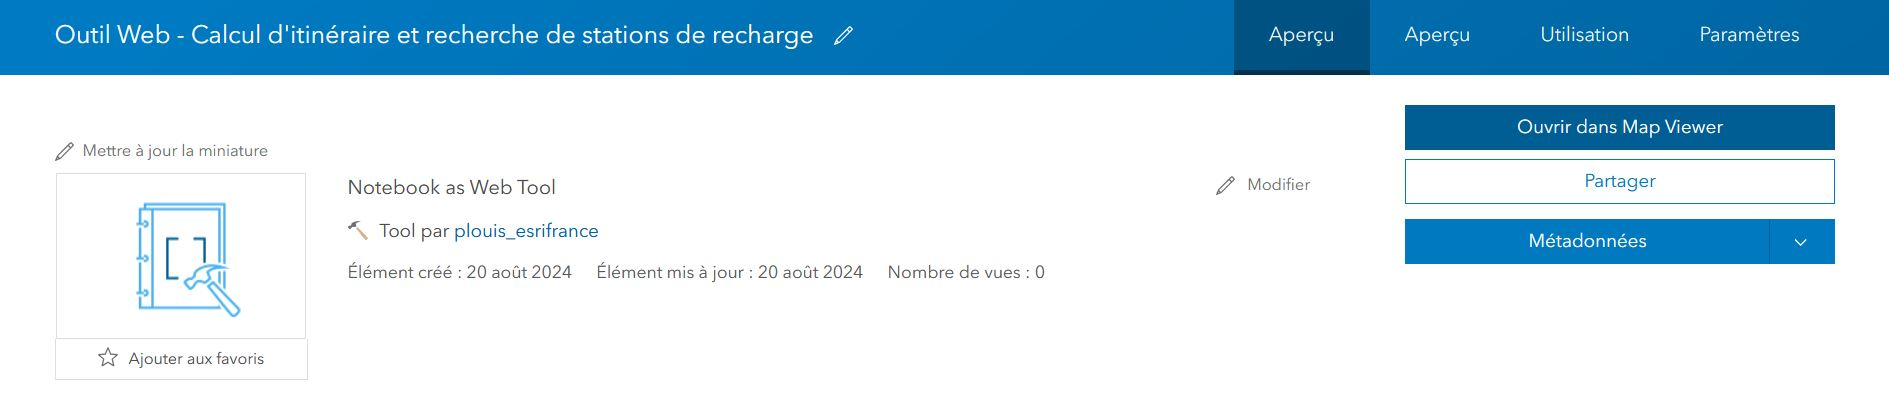

2. Cliquez sur le bouton "Dessiner les entités d'entrée" à côté du  **Point de départ** et placez un point où vous le souhaitez en Amérique du Nord. Faites de même pour la **Destination**.
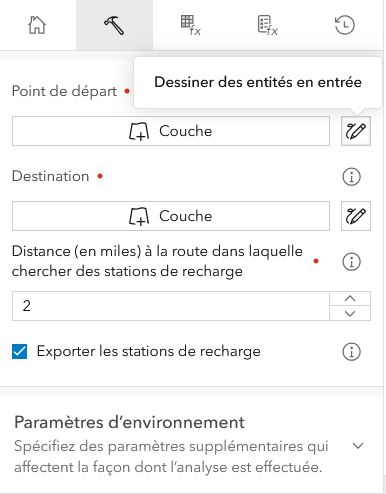

3. Si vous le souhaitez, vous pouvez changer la distance de recherche des stations de recharge.

4. Exécutez l'outil. Dans l'onglet couche, vous verrez apparaître la couche d'itinéraire, la couche des stations de recharge et les points de départ et de destination. 

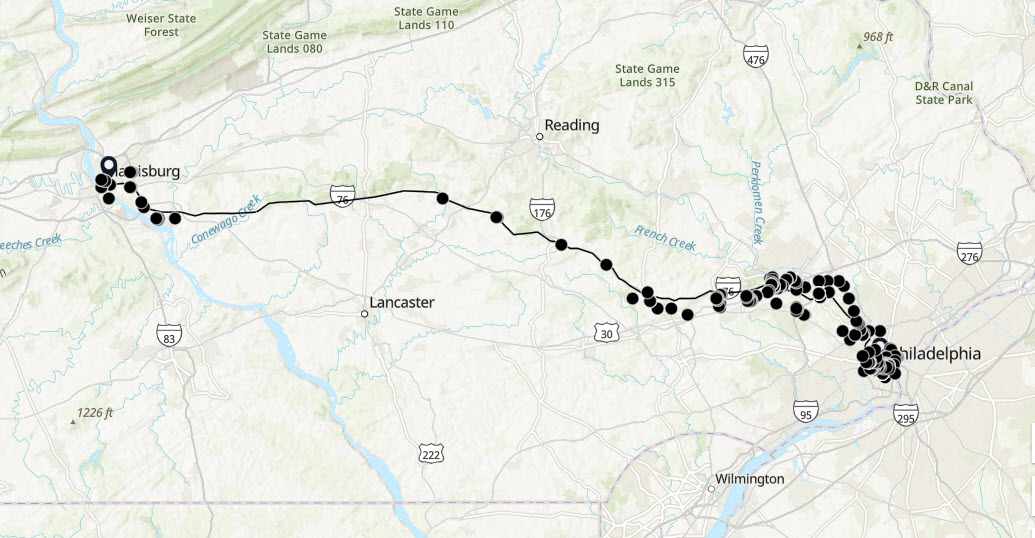

## Conclusion

Vous savez maintenant comment créer un Notebook, en configurer des paramètres d'entrée et de sortie et le publier en tant qu'outil web pour l'utiliser dans une application tierce comme le Map Viewer. Vous pouvez également l'insérer dans un application Experience Builder grâce au [widget Analyse](https://doc.arcgis.com/en/web-appbuilder/latest/create-apps/widget-geoprocessing.htm). Pour aller plus loin, vous pouvez retrouver toute la documentation sur la publication des Notebooks sous forme d'outil web dans [cette documentation](https://doc.arcgis.com/fr/arcgis-online/create-maps/publish-a-notebook-as-a-web-tool.htm).  
Si vous souhaitez en apprendre plus sur l'analyse avec l'API Python d'ArcGIS afin de scripter vos propres outils, n'hésitez pas à consulter [ce tutoriel disponible sur CodeTheMap](https://www.codethemap.fr/2024/08/api-python-arcgis-analyse-services-localisation.html).